In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [86]:
from tools.loss import *
from tools.uncertainty import *

In [2]:
os.chdir('/data/txw190000/Workspace/SeaBird/HoP/tmp/hop_seabird_r50_256x704')

# 1.  LOAD DATA

In [72]:
# Traverse all .npy files in the directory
directory = 'semantic_pred'
preds = []
for filename in os.listdir(directory):
    if filename.endswith('.npy'):
        # Load the .npy file
        file_path = os.path.join(directory, filename)
        pred = np.load(file_path).transpose(1,2,0)
        preds.append(pred)
preds = np.stack(preds, axis=0)

directory = 'semantic_map'
gds = []
for filename in os.listdir(directory):
    if filename.endswith('.npy'):
        # Load the .npy file
        file_path = os.path.join(directory, filename)
        gd = np.load(file_path).squeeze(0).transpose(1,2,0)
        gds.append(gd)
gds = np.stack(gds, axis=0)

directory = 'bev_features'
feats = []
for filename in os.listdir(directory):
    if filename.endswith('.npy'):
        # Load the .npy file
        file_path = os.path.join(directory, filename)
        ft = np.load(file_path).squeeze(0).transpose(1,2,0)
        feats.append(ft)
feats = np.stack(feats, axis=0)

In [74]:
print('ground truth shape', gds.shape)
print('prediction shape', preds.shape)
print('feats shape', feats.shape)

ground truth shape (6019, 200, 200, 5)
prediction shape (6019, 200, 200, 5)
feats shape (6019, 128, 128, 256)


In [5]:
# therea re 5 classes in the current prediction and ground truth pair (with a binary classification way)
np.max(gds.sum(axis=-1))

4

# 2. CONFIDENCE SCORE for CALIBRATION and MISCLASSIFICATION DETECTION

In [6]:
# Get the probability by apply a sigmoid function on each class
preds_prob = 1 / (1 + np.exp(-preds))

confs=[]
# five classes
for i in range(5):
    preds_prob_2dimension = np.stack([1.0-preds_prob[:,:,:,i], preds_prob[:,:,:,i]], axis=-1)
    conf = np.max(preds_prob_2dimension, axis=-1)
    confs.append(conf)
confs = np.stack(confs, axis=-1)

/tmp/ipykernel_67763/2466757900.py:2: RuntimeWarning: overflow encountered in exp
  preds_prob = 1 / (1 + np.exp(-preds))


## TO DO

In [7]:
## For each class, based on ground truth and confidence score, calcualte the ECE and misclassification AUROC and AUPR


# 3. train uncertainty head and take the preds as input, and the ground truth as the label.

## Remeber, we use UCE loss and UFCE loss for training (we can use single class training or try multiple classes)

In [79]:
## Neural network architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self, in_channels, inter_channels, task_dim):
        super(SimpleNet, self).__init__()
        
        # Define the task head
        self.task_head = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, inter_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(200, 200), mode='bilinear', align_corners=True),
            nn.Conv2d(inter_channels, task_dim, kernel_size=1, padding=0)
        )
    
    def forward(self, x):
        # Forward pass through the task head
        out = self.task_head(x)
        return out

In [87]:
def activate(alpha):
    return alpha / torch.sum(alpha, dim=1, keepdim=True)

In [95]:
# define net
unc_head = SimpleNet(in_channels=256, inter_channels=16, task_dim=2).to(4) # assume logit inputs and bin. class.
opt = torch.optim.Adam(
        unc_head.parameters(),
        lr=1e-3,
        weight_decay=1e-7
    )
# training loop
for e in range(10):
    for i in range(len(preds)):
        feat = feats[i, :, :, :][None]
        gt = gds[i, :, :, 0][None][None]
    
        feat = torch.tensor(feat).to(4).permute(0, 3, 1, 2)
        gt = torch.tensor(gt).to(4)
    
        gt = torch.cat((gt, ~gt), dim=1)
    
        alpha = unc_head(feat).relu() + 1
        loss = uce_loss(alpha, gt).mean()
        
        loss.backward()
        nn.utils.clip_grad_norm_(unc_head.parameters(), 5.0)
        opt.step()
        
        if i % 500 == 0:
            print(loss.item())

0.7728230357170105
0.12995915114879608
0.051159970462322235
0.04788726195693016
0.0723767951130867
0.01774255558848381
0.04132973030209541
0.010772344656288624
0.026833580806851387
0.016312502324581146
0.03958889842033386
0.04576713964343071
0.05495356768369675
0.0017284125788137317
0.049024906009435654
0.02050691656768322
0.03328661248087883
0.0666482150554657
0.011194203048944473
0.03396708145737648
0.008100321516394615
0.022278951480984688
0.016130205243825912
0.04084935039281845
0.048506032675504684
0.053186070173978806
0.0006911556120030582
0.04902200773358345
0.019254501909017563
0.03287037834525108
0.06855498999357224
0.010595898143947124
0.03402642533183098
0.007710687816143036
0.022131305187940598
0.016448549926280975
0.03886191174387932
0.04780229553580284
0.05511569604277611
0.001207667519338429
0.05052069574594498
0.018385134637355804
0.033333390951156616
0.07020758837461472
0.010485761798918247
0.03377016261219978
0.008071942254900932
0.021828293800354004
0.015550267882645

In [83]:
alpha = unc_head(feat).relu() + 1


In [84]:
alpha.max()

tensor(1304.5660, device='cuda:4', grad_fn=<MaxBackward1>)

In [89]:
probs = activate(alpha)
epis = vacuity(alpha)

In [90]:
probs.max()

tensor(0.9992, device='cuda:4', grad_fn=<MaxBackward1>)

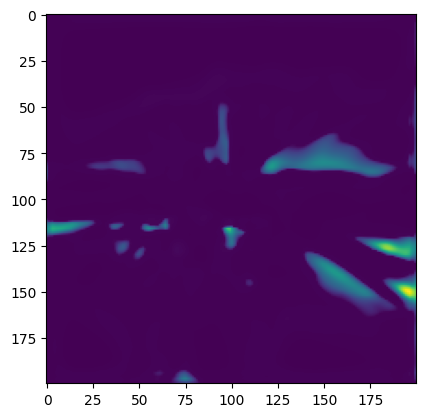

In [93]:
plt.imshow(probs.detach().cpu().numpy()[0, 0])

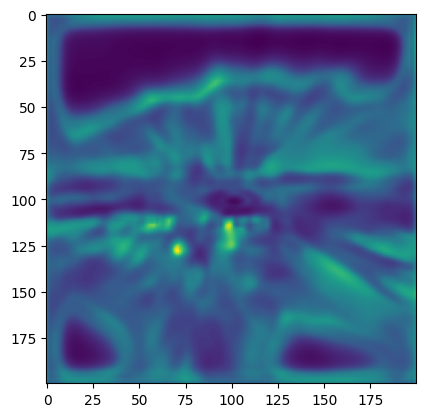

In [94]:
plt.imshow(epis.detach().cpu().numpy()[0, 0])

# TO DO

# SAMPLE VISUALIZATION

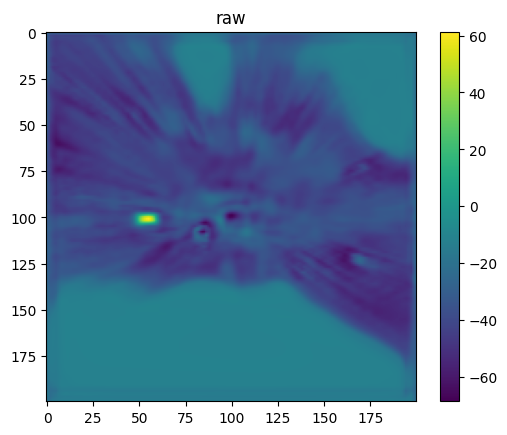

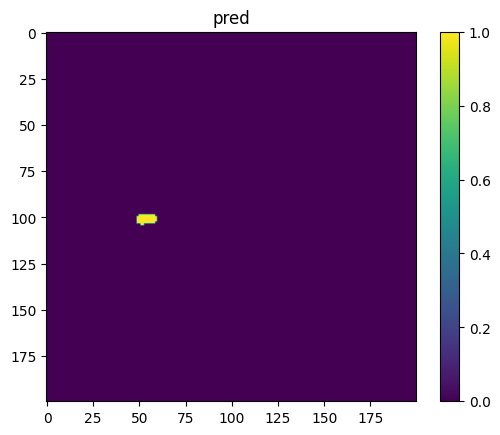

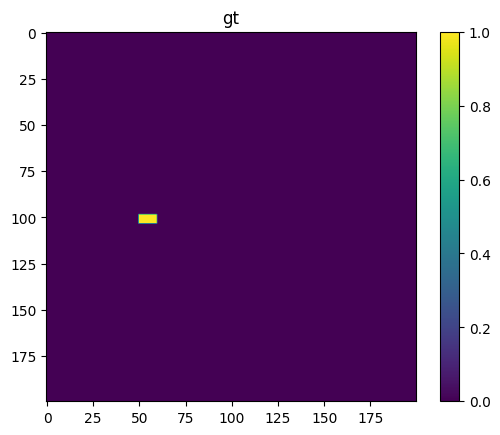

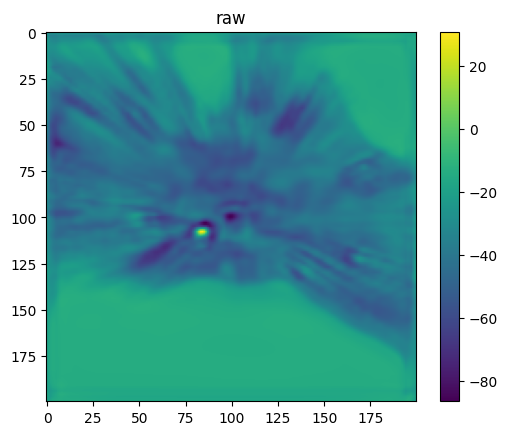

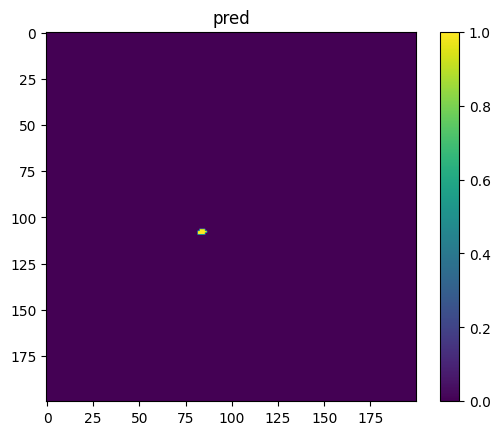

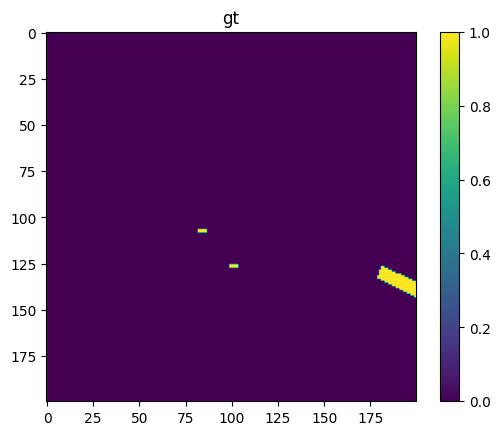

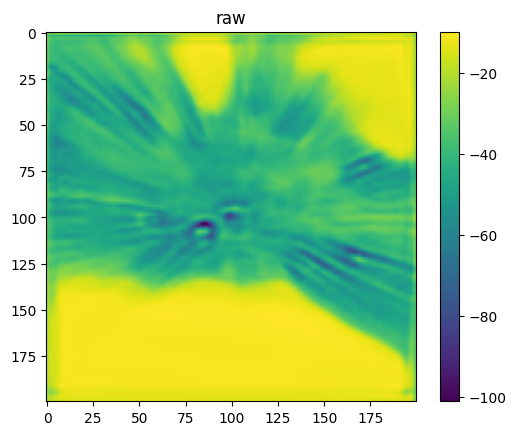

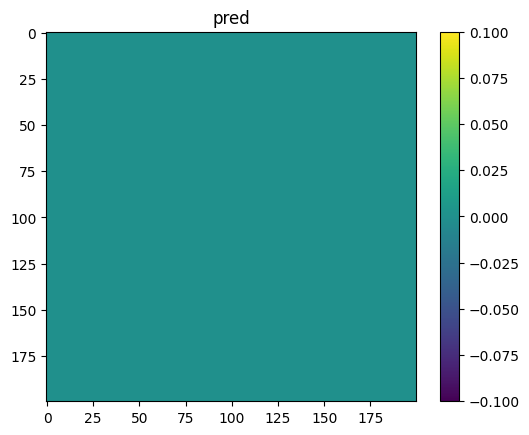

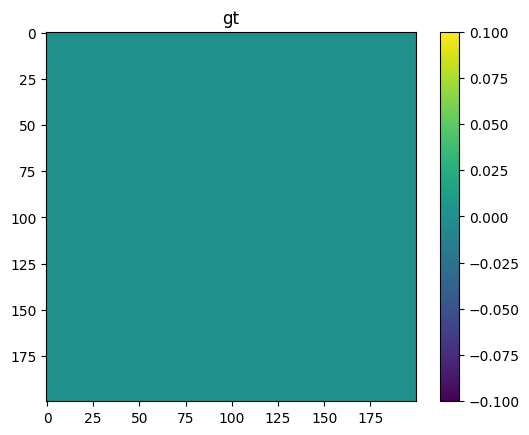

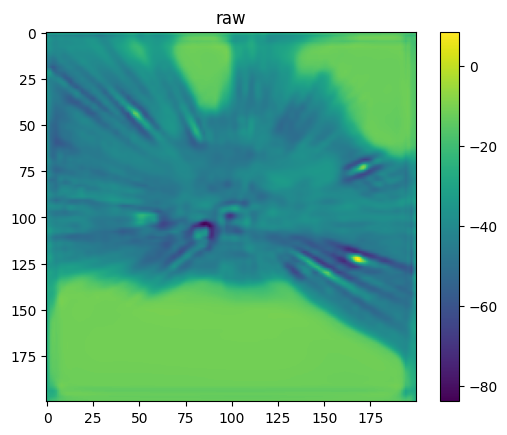

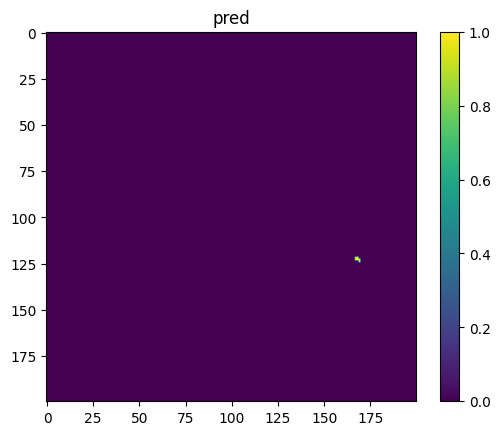

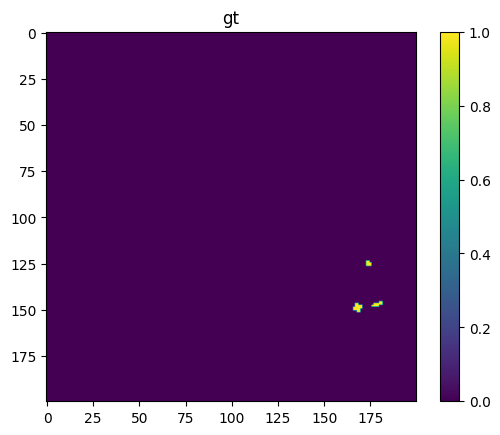

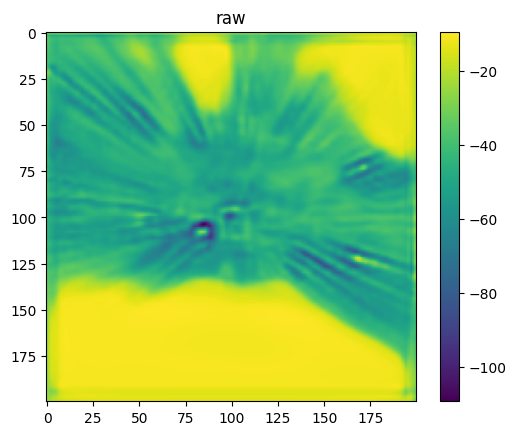

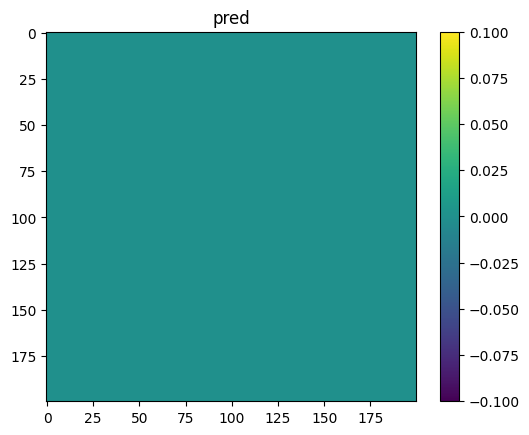

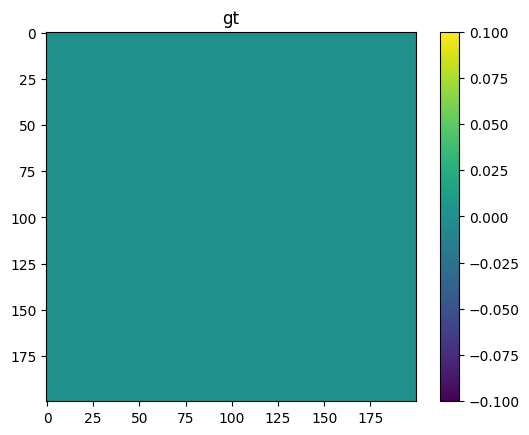

In [4]:
pred = np.load('semantic_pred/n015-2018-07-11-11-54-16+0800__LIDAR_TOP__1531281439800013.pcd.bin.npy').transpose(1,2,0)
gt = np.load('semantic_map/n015-2018-07-11-11-54-16+0800__LIDAR_TOP__1531281439800013.pcd.bin.npy').squeeze(0).transpose(1, 2, 0)
thres = 0.25
 
for cls in range(5):
    plt.title('raw')
    plt.imshow(pred[:,:,cls])
    plt.colorbar()
    plt.show()
 
    plt.title('pred')
    plt.imshow(pred[:,:,cls]>thres)
    plt.colorbar()
    plt.show()
 
    plt.title('gt')
    plt.imshow(gt[:,:,cls])
    plt.colorbar()
    plt.show()

In [17]:
# # Step 2: Calculate ECE score
# def calculate_ece(preds, labels, n_bins=15):
#     preds = np.reshape(preds, (-1, preds.shape[-1]))
#     labels = np.reshape(labels, -1)
    
#     confidences = np.max(preds, axis=-1)
#     predictions = np.argmax(preds, axis=-1)
#     accuracies = predictions == labels
    
#     bin_boundaries = np.linspace(0, 1, n_bins + 1)
#     bin_lowers = bin_boundaries[:-1]
#     bin_uppers = bin_boundaries[1:]
    
#     ece = 0.0
#     for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
#         in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
#         prop_in_bin = np.mean(in_bin)
#         if prop_in_bin > 0:
#             accuracy_in_bin = np.mean(accuracies[in_bin])
#             avg_confidence_in_bin = np.mean(confidences[in_bin])
#             ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
#     return ece

# ece_score = calculate_ece(softmax_pred, gd)

# # Step 3: Calculate AUROC and AUPR for misclassification detection
# # Flatten the arrays for binary classification
# softmax_pred_flat = softmax_pred.reshape(-1, softmax_pred.shape[-1])
# gd_flat = gd.reshape(-1)

# # True labels for misclassification detection: 1 if misclassified, 0 if correctly classified
# true_labels = (np.argmax(softmax_pred_flat, axis=-1) != gd_flat).astype(int)

# # Probability of being misclassified
# misclassification_probs = 1 - np.max(softmax_pred_flat, axis=-1)

# # Calculate AUROC
# auroc = roc_auc_score(true_labels, misclassification_probs)

# # Calculate AUPR
# precision, recall, _ = precision_recall_curve(true_labels, misclassification_probs)
# aupr = auc(recall, precision)

# # Output results
# print("ECE Score:", ece_score)
# print("AUROC:", auroc)
# print("AUPR:", aupr)

ECE Score: 0.44506192421242596
AUROC: 0.682136441991646
AUPR: 0.8641631725541424
